In [1]:
import Trial_Processing as pts
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import config
import tdt
import cv2

## Manual Loading Data
If you have the paths to the data but the names arent aligned or if you dont want to run the autoalignment script you can manually load the data 

### write_photometry_to_csv parameters
@param: CSV_path - string containing the path to the CSV file

@param: Video_path - string containing the path to the video file

@param: Photometry_path - string containing the path to the photometry file

@param: output_path - string containing the path to the folder to save the CSV file to

@param: F1_name - string containing the name of the first mouse

@param: F2_name - string containing the name of the second mouse

@param: trial_duration - int containing the length of the trial in seconds, by default 30, this should be how long the light was turned on for in the trial

@param: skip_trials - int containing the number of trials to skip at the beginning of the data, by default 1, this is to skip the first trial which is usually before the experiment starts

@param: sample_rate - float containing the sample rate of the photometry data, by default 1017 (fs of the TDT system)
@param: cue_offset_seconds - the signed offset between the cue and the trigger sent to the photmetry data in seconds, e.g. if the trigger was 5 seconds before the cue 
it would be -5

@param: use_time_alignment - bool, if true then the it will use the start datetimes of the CSV file and the video file to align the data, if false then it will use the skip trials parameter to align the data

@return - df - pandas dataframe containing the photometry data, with each trial labelled, as well as video timestamps for each entry


In [2]:
df = pts.write_photometry_to_csv(
    CSV_path = '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/October Test Data/csv files/20231005093139_log.csv', 
    Video_path = '/mnt/teams/TM_Lab/Arjun Bhaskaran/Social interaction project/October Test Data/videos/20231005093138_SI.h264', 
    Photometry_path = config.remote_photometry_path + '/Social_Interaction-231005/M3_F1_M4_F2', 
    output_path = None, 
    F1_name = 'M5', 
    F2_name = 'M6', 
    trial_duration=30, 
    skip_trials=1, 
    sample_rate=45, 
    cue_offset_seconds=5,
    use_time_alignment=True
)

read from t=0s to t=35750.1s
Offsetting photometry data by 4230 samples
1653039
Number of trials: 697
696


In [4]:
photo_data = pts.PhotometryVideoData(df=df, trim_start=20)

In [3]:
def zscore(data):
    return (data - np.mean(data))/np.std(data)

In [ ]:
trial_number = 10
video = photo_data.get_video_data(trial_number)
traceA = zscore(photo_data.get_photometry_data(trial_number)['465A'])
traceB = zscore(photo_data.get_photometry_data(trial_number)['405A'])


887


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f04423e36d0>
Traceback (most recent call last):
  File "/home/murph_4090ws/.local/lib/python3.10/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


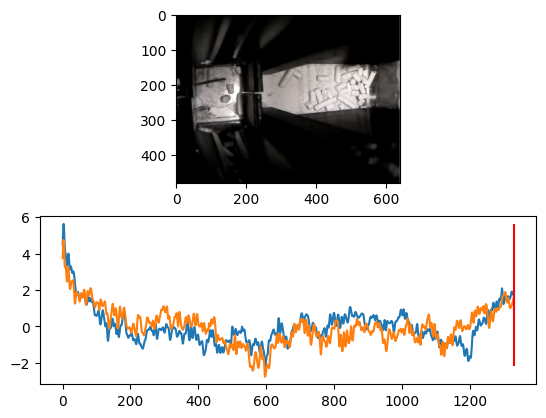

In [12]:
from matplotlib.animation import FuncAnimation

def plot_series_under_video(data, sample_rate, trial_number):
    video = photo_data.get_video_data(trial_number)
    traceA = zscore(photo_data.get_photometry_data(trial_number)['465A'])
    traceB = zscore(photo_data.get_photometry_data(trial_number)['405A'])

    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.imshow(video[0])
    ax2.plot(traceA)
    ax2.plot(traceB)
    line = ax2.vlines(0, min(traceA), max(traceA), color='r')

    def update(frame):
        ax1.clear()
        ax1.imshow(video[frame])
        ax2.clear()
        ax2.plot(traceA)
        ax2.plot(traceB)
        ax2.vlines(((frame * sample_rate) // 30), min(traceA), max(traceA), color='r')
        return line,

    print(len(video))
    ani = FuncAnimation(fig, update, frames=len(video), interval=33, blit=True)
    ## save the animation as an mp4.
    ani.save('test.mp4',fps=30, extra_args=['-vcodec', 'libx264'])
    plt.show()


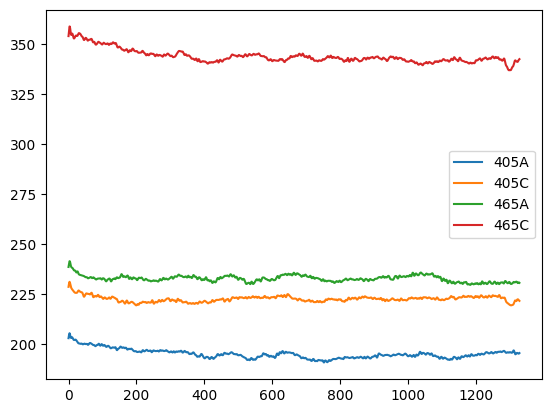

In [41]:
## You can use get_photometry_data to get the photometry data for a specific trial
## The first argument is the trial number (0-indexed)
## Returns a dict keyed by the 4 different channels (405A, 405C, 465A, 465C)
plt.plot(photo_data.get_photometry_data(3)['405A'], label='405A')
plt.plot(photo_data.get_photometry_data(3)['405C'], label='405C')
plt.plot(photo_data.get_photometry_data(3)['465A'], label='465A')
plt.plot(photo_data.get_photometry_data(3)['465C'], label='465C')
plt.legend()
plt.show()

In [42]:
## You Can Use get_trial_data to get all the experimental data for a given trial
display(photo_data.get_trial_data(1))

cue_time in s                    20231005093235596856
trig_fib_photometry_time in s    20231005093230587814
M5_L_rewards                                        0
M5_L_beambreak_time in s                          NaN
M5_L_reward time in s                             NaN
M6_R_rewards                                        0
M6_R_beambreak_time in s                          NaN
M6_R_reward time in s                             NaN
M5_L_beambreak_time                 1696523571.619023
M5_L_reward time                                  NaN
M6_R_beambreak_time                 1696523571.621194
M6_R_reward time                                  NaN
cue_time                            1696523555.596856
trig_fib_photometry_time            1696523550.587814
Name: 1, dtype: object

In [94]:
successful_trials = []
failed_trials = []
for i in range(len(photo_data)):
    photometry = photo_data.get_photometry_data(i)
    trial = photo_data.get_trial_data(i)
    ## We have to find the names of the indexes for the break times manually
    break_time_one = float(trial['M5_L_beambreak_time in s'])
    break_time_two = float(trial['M6_R_beambreak_time in s'])
    ## If both break times are NaN, then the trial was not successful
    trial_successful = (~(np.isnan(float(break_time_one)) and np.isnan(float(break_time_two))))
    if trial_successful:
        successful_trials.append(photometry)
    else:
        failed_trials.append(photometry)

In [132]:
from scipy.optimize import curve_fit
def exp_fit_sub(data, method='exp_fit'):
    t = np.arange(len(data)) / 45
    guess_a, guess_b, guess_c = np.max(data), -0.05, np.min(data)
    guess = [guess_a, guess_b, guess_c]
    exp_decay = lambda x, A, b, y0: A * np.exp(x * b) + y0
    params, cov = curve_fit(exp_decay, t, data, p0=guess, maxfev=5000)
    A, b, y0 = params
    best_fit = lambda x: A * np.exp(b * x) + y0
    dff = data-best_fit(t) + 100  # add DC offset so mean of corrected signal is positive
    return dff

def dff_zscore(trace, baseline):
    mean_trace = np.mean(trace)
    mean_baseline = np.mean(baseline)
    corrected_signal = trace / mean_trace - baseline / mean_baseline
    #corrected_signal = exp_fit_sub(corrected_signal)
    return (corrected_signal - np.mean(corrected_signal, axis=0)) / np.std(corrected_signal)

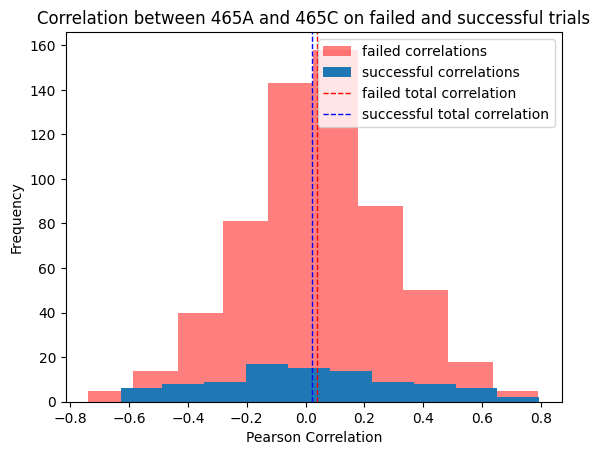

In [133]:
from scipy.stats import pearsonr
## plot all the successful trials
correlations_success = []
correlations_fail = []
sucessful_zscores_A = []
sucessful_zscores_C = []
failed_zscores_A = []
failed_zscores_C = []
for trial in successful_trials:
    z_score_A = (dff_zscore(trial['465A'], trial['405A']))
    z_score_C = (dff_zscore(trial['465C'], trial['405C']))
    sucessful_zscores_A.extend(z_score_A)
    sucessful_zscores_C.extend(z_score_C)
    correlation = pearsonr(z_score_A, z_score_C)[0]
    correlations_success.append(correlation)
for trial in failed_trials:
    z_score_A = (dff_zscore(trial['465A'], trial['405A']))
    z_score_C = (dff_zscore(trial['465C'], trial['405C']))
    failed_zscores_A.extend(z_score_A)
    failed_zscores_C.extend(z_score_C)
    correlation = pearsonr(z_score_A, z_score_C)[0]
    correlations_fail.append(correlation)

## Total correlation successful
total_success_corr_ind = pearsonr(sucessful_zscores_A, sucessful_zscores_C)[0]
## Total correlation failed
total_fail_corr_ind = pearsonr(failed_zscores_A, failed_zscores_C)[0]
## Plot a histogram of the correlations
plt.hist(correlations_fail, alpha=0.5, color='red', label='failed correlations')
plt.hist(correlations_success, alpha=1, label='successful correlations')
## plot a line at the means of each
plt.axvline((total_fail_corr_ind), color='red', linestyle='dashed', linewidth=1, label='failed total correlation')
plt.axvline((total_success_corr_ind), color='blue', linestyle='dashed', linewidth=1, label='successful total correlation')
plt.legend()
plt.title('Correlation between 465A and 465C on failed and successful trials')
plt.xlabel('Pearson Correlation')
plt.ylabel('Frequency')
plt.show()


Total successful correlation:  -0.19350668225007656
Total failed correlation:  0.1942375161617962


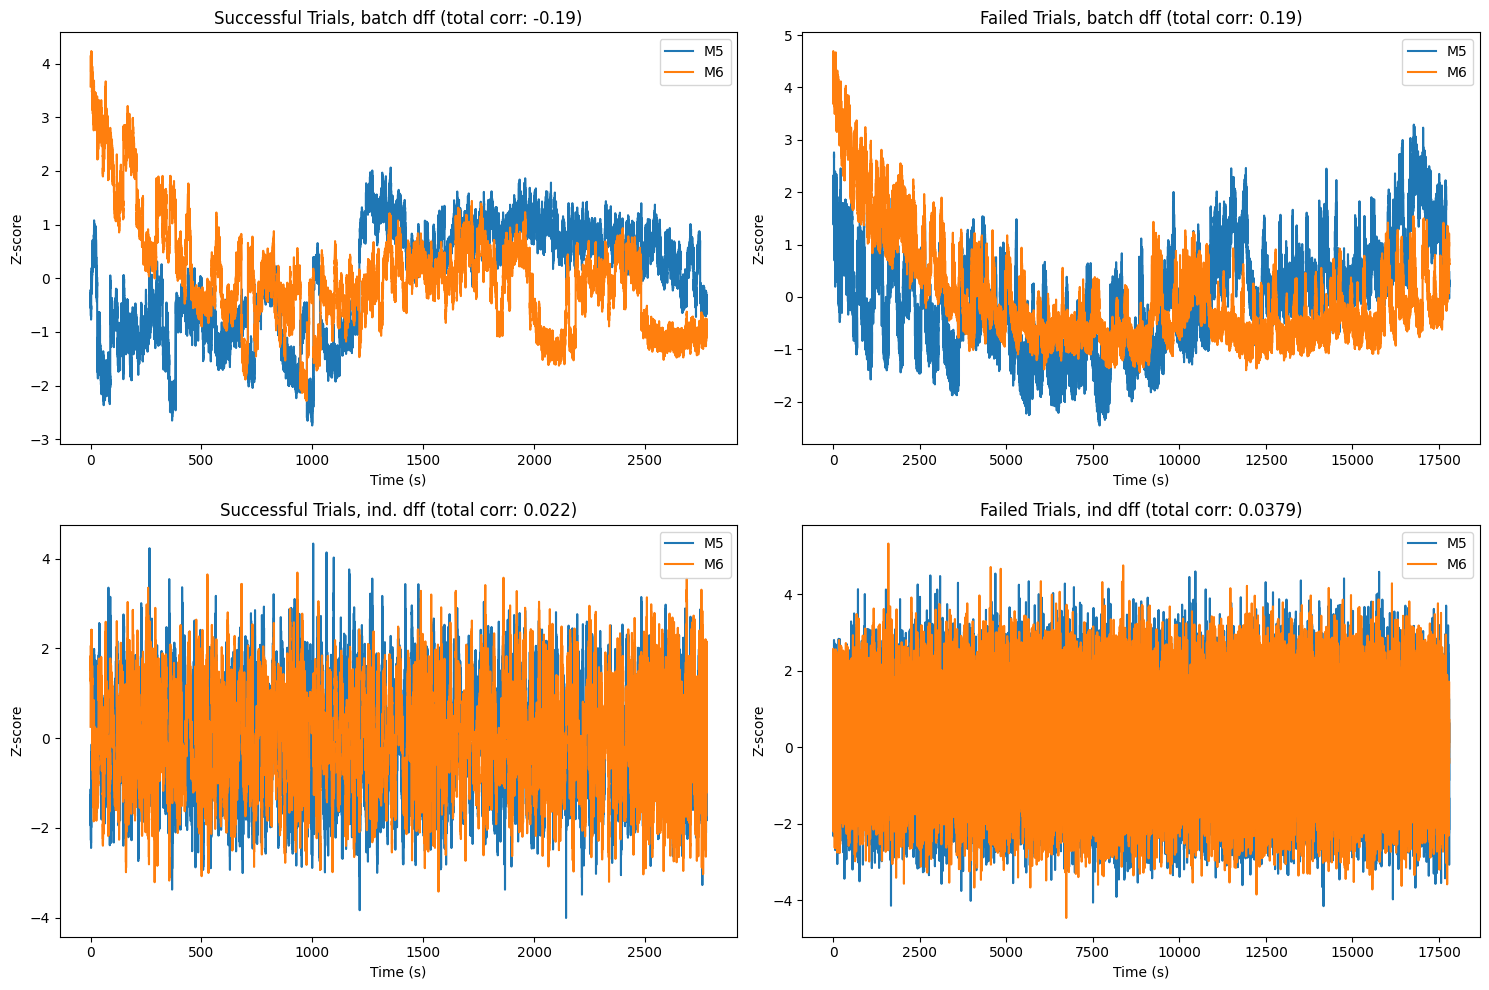

In [134]:
## concat together all the successful trial dicts
sample_rate = 45
for i in range(len(successful_trials)):
    if i == 0:
        concat_success = None
        concat_success = successful_trials[0].copy()
    else:
        concat_success['405A'] = np.concatenate((concat_success['405A'], successful_trials[i]['405A']))
        concat_success['405C'] = np.concatenate((concat_success['405C'], successful_trials[i]['405C']))
        concat_success['465A'] = np.concatenate((concat_success['465A'], successful_trials[i]['465A']))
        concat_success['465C'] = np.concatenate((concat_success['465C'], successful_trials[i]['465C']))

## concat together all the failed trial dicts
for i in range(len(failed_trials)):
    if i == 0:
        concat_fail = failed_trials[0].copy()
    else:
        concat_fail['405A'] = np.concatenate((concat_fail['405A'], failed_trials[i]['405A']))
        concat_fail['405C'] = np.concatenate((concat_fail['405C'], failed_trials[i]['405C']))
        concat_fail['465A'] = np.concatenate((concat_fail['465A'], failed_trials[i]['465A']))
        concat_fail['465C'] = np.concatenate((concat_fail['465C'], failed_trials[i]['465C']))

## compute z-score of concated series
z_score_A_success = (dff_zscore(concat_success['465A'], concat_success['405A']))
z_score_C_success = (dff_zscore(concat_success['465C'], concat_success['405C']))
z_score_A_fail = (dff_zscore(concat_fail['465A'], concat_fail['405A']))
z_score_C_fail = (dff_zscore(concat_fail['465C'], concat_fail['405C']))

## calculate correlation of concated series
total_success_corr = pearsonr(z_score_A_success, z_score_C_success)[0]
total_fail_corr = pearsonr(z_score_A_fail, z_score_C_fail)[0]

## print the correlations
print('Total successful correlation: ', total_success_corr)
print('Total failed correlation: ', total_fail_corr)

## plot the individual z-score traces
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False)
## increase the size of the figure
fig.set_size_inches(15, 10)
time_success = np.arange(len(z_score_A_success)) / sample_rate
time_fail = np.arange(len(z_score_A_fail)) / sample_rate
ax1.plot(time_success, z_score_A_success, label='M5')
ax1.plot(time_success, z_score_C_success, label='M6')
ax1.set_title('Successful Trials, batch dff' + ' (total corr: ' + str(round(total_success_corr, 2)) + ')')
ax1.legend()
ax2.plot(time_fail, z_score_A_fail, label='M5')
ax2.plot(time_fail, z_score_C_fail, label='M6')
ax2.set_title('Failed Trials, batch dff' + ' (total corr: ' + str(round(total_fail_corr, 2)) + ')')
ax2.legend()
ax3.plot(time_success,sucessful_zscores_A, label='M5')
ax3.plot(time_success, sucessful_zscores_C, label='M6')
ax3.set_title('Successful Trials, ind. dff' + ' (total corr: ' + str(round(total_success_corr_ind, 4)) + ')')
ax3.legend()
ax4.plot(time_fail,failed_zscores_A, label='M5')
ax4.plot(time_fail,failed_zscores_C, label='M6')
ax4.set_title('Failed Trials, ind dff' + ' (total corr: ' + str(round(total_fail_corr_ind, 4)) + ')')
ax4.legend()
## add x and y labels for z-score and samples
for ax in fig.get_axes():
    ax.set(xlabel='Time (s)', ylabel='Z-score')

## make space for the title
fig.tight_layout()
plt.show()

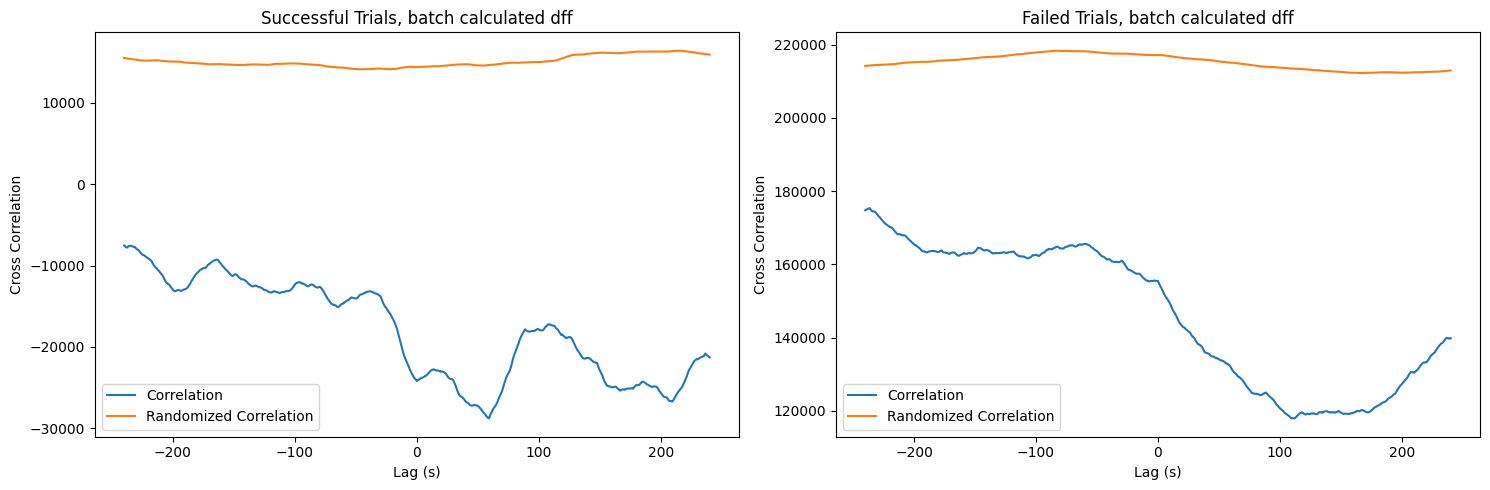

In [135]:
## calculate cross correlation between z_score_A_success and z_score_C_success and compare to phase randomized versions of the data
from scipy.signal import correlate

## function to phase randomize a signal
def phase_randomize(signal):
    ## take the fft of the signal
    signal_fft = np.fft.fft(signal)
    ## generate a random phase
    random_phase = np.exp(np.random.uniform(0, 2*np.pi, len(signal)) * 1j ) 
    ## multiply the fft of the signal by the random phase
    randomized_signal = np.fft.ifft(signal_fft * random_phase)
    return randomized_signal

def calc_correlation(signal1, signal2):
    corr = correlate(signal1, signal2)
    corr_randomized = np.zeros(len(corr))
    for i in range(100):
        corr_randomized += np.abs(correlate(phase_randomize(signal1), phase_randomize(signal2)))
    corr_randomized /= 100
    time_series = (np.arange(len(corr_randomized) ) - len(corr_randomized) // 2)/ sample_rate
    return corr, corr_randomized, time_series

corr_succ, corr_randomized_succ, time_series_succ = calc_correlation(z_score_A_success, z_score_C_success)

corr_fail, corr_randomized_fail, time_series_fail = calc_correlation(z_score_A_fail, z_score_C_fail)

## Trim all to +/- 120 seconds 
center = len(corr_succ) // 2
trim = 240 * sample_rate
corr_succ = corr_succ[center - trim:center + trim]
corr_randomized_succ = corr_randomized_succ[center - trim:center + trim]
time_series_succ = time_series_succ[center - trim:center + trim]
center = len(corr_fail) // 2
corr_fail = corr_fail[center - trim:center + trim]
corr_randomized_fail = corr_randomized_fail[center - trim:center + trim]
time_series_fail = time_series_fail[center - trim:center + trim]



fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False)
## increase the size of the figure
fig.set_size_inches(15, 5)
ax1.plot(time_series_succ, corr_succ, label='Correlation')
ax1.plot(time_series_succ, corr_randomized_succ, label='Randomized Correlation')
ax1.set_title('Successful Trials, batch calculated dff')
ax1.legend()
ax2.plot(time_series_fail, corr_fail, label='Correlation')
ax2.plot(time_series_fail, corr_randomized_fail, label='Randomized Correlation')
ax2.set_title('Failed Trials, batch calculated dff')
ax2.legend()
## add x and y labels for z-score and samples
for ax in fig.get_axes():
    ax.set(xlabel='Lag (s)', ylabel='Cross Correlation')

## make space for the title
fig.tight_layout()
plt.show()


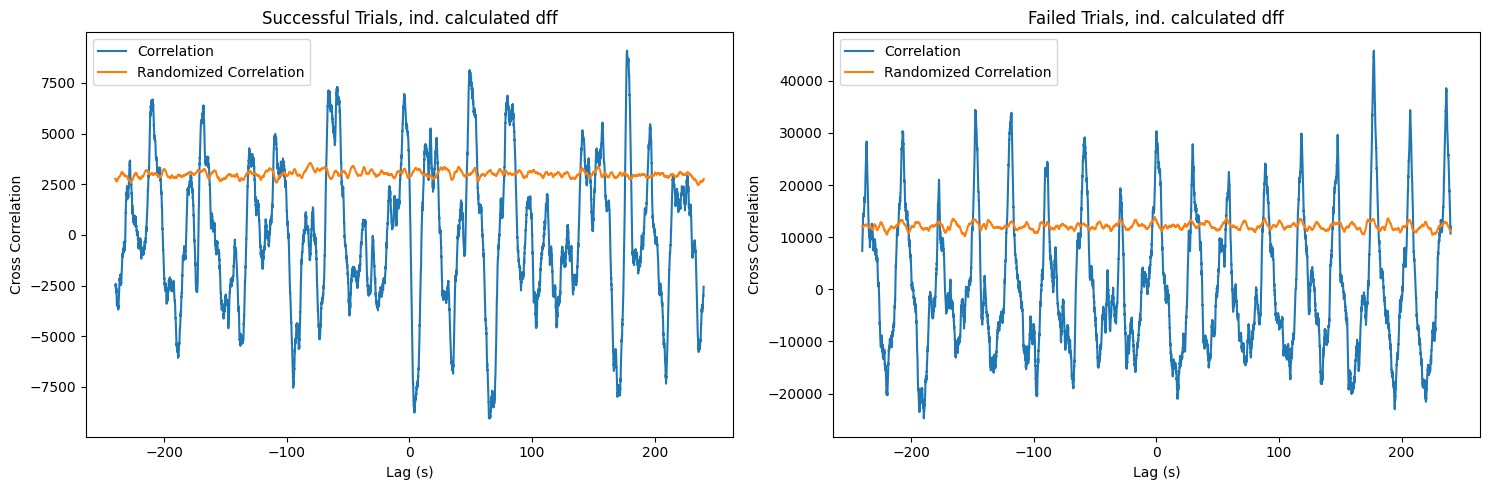

In [136]:

corr_succ, corr_randomized_succ, time_series_succ = calc_correlation(sucessful_zscores_A, sucessful_zscores_C)

corr_fail, corr_randomized_fail, time_series_fail = calc_correlation(failed_zscores_A, failed_zscores_C)

## Trim all to +/- 120 seconds 
center = len(corr_succ) // 2
trim = 240 * sample_rate
corr_succ = corr_succ[center - trim:center + trim]
corr_randomized_succ = corr_randomized_succ[center - trim:center + trim]
time_series_succ = time_series_succ[center - trim:center + trim]
center = len(corr_fail) // 2
corr_fail = corr_fail[center - trim:center + trim]
corr_randomized_fail = corr_randomized_fail[center - trim:center + trim]
time_series_fail = time_series_fail[center - trim:center + trim]



fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False)
## increase the size of the figure
fig.set_size_inches(15, 5)
ax1.plot(time_series_succ, corr_succ, label='Correlation')
ax1.plot(time_series_succ, corr_randomized_succ, label='Randomized Correlation')
ax1.set_title('Successful Trials, ind. calculated dff')
ax1.legend()
ax2.plot(time_series_fail, corr_fail, label='Correlation')
ax2.plot(time_series_fail, corr_randomized_fail, label='Randomized Correlation')
ax2.set_title('Failed Trials, ind. calculated dff')
ax2.legend()
## add x and y labels for z-score and samples
for ax in fig.get_axes():
    ax.set(xlabel='Lag (s)', ylabel='Cross Correlation')

## make space for the title
fig.tight_layout()
plt.show()

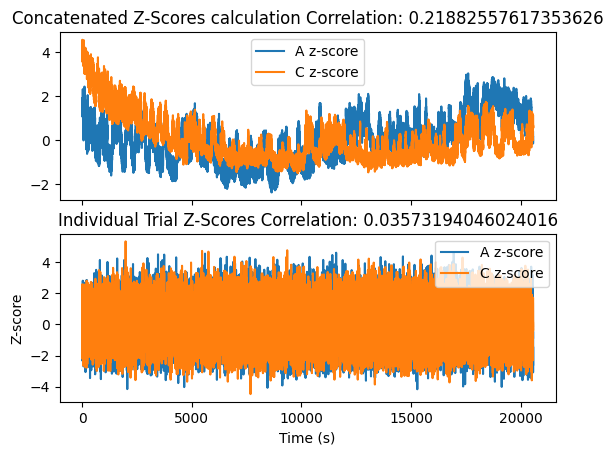

In [137]:
## Create 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

## flatten the data into a single array
flattened_405A = (photo_data.get_all_photometry_data()['405A'].flatten())
flattened_405C = (photo_data.get_all_photometry_data()['405C'].flatten())
flattened_465A = (photo_data.get_all_photometry_data()['465A'].flatten())
flattened_465C = (photo_data.get_all_photometry_data()['465C'].flatten())
## calculate the z-score of the flattened data
z_score_A = (dff_zscore(flattened_465A, flattened_405A))
z_score_C = (dff_zscore(flattened_465C, flattened_405C))

## calculate time series
sample_rate = photo_data.sample_rate
time_series = np.linspace(0, len(z_score_A) / sample_rate, len(z_score_A))

## plot the z-scored data
ax1.plot(time_series, z_score_A, label='A z-score')
ax1.plot(time_series, z_score_C, label='C z-score')
ax1.legend()
corr = pearsonr(z_score_A, z_score_C)[0]
ax1.title.set_text('Concatenated Z-Scores calculation' + ' Correlation: ' + str(corr))

z_score_A_individual_calculation = []
z_score_C_individual_calculation = []

## calculate z-score for each individual trial
for i in range(len(photo_data)):
    photometry = photo_data.get_photometry_data(i)
    z_score_A_individual_calculation.extend(dff_zscore(photometry['465A'], photometry['405A']))
    z_score_C_individual_calculation.extend(dff_zscore(photometry['465C'], photometry['405C']))

ax2.plot(time_series, z_score_A_individual_calculation, label='A z-score')
ax2.plot(time_series, z_score_C_individual_calculation, label='C z-score')
ax2.legend()
corr = pearsonr(z_score_A_individual_calculation, z_score_C_individual_calculation)[0]
ax2.title.set_text('Individual Trial Z-Scores' + ' Correlation: ' + str(corr))

## Label axes
plt.xlabel('Time (s)')
plt.ylabel('Z-score')
plt.show()

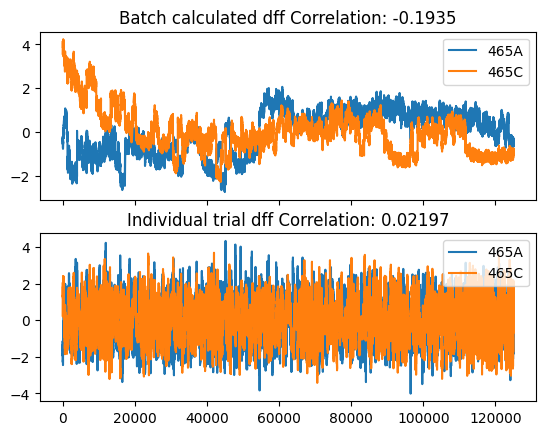

In [138]:
## Create 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# plot
# take moving average of z-scored data
window_size = 400
ax1.plot(z_score_A_success, label='465A')
ax1.plot(z_score_C_success, label='465C')
corr = pearsonr(z_score_A_success, z_score_C_success)[0]
ax1.legend()
ax1.set_title('Batch calculated dff' + ' Correlation: ' + str(corr)[:7])
ax2.plot(sucessful_zscores_A, label='465A')
ax2.plot(sucessful_zscores_C, label='465C')
corr = pearsonr(sucessful_zscores_A, sucessful_zscores_C)[0]
ax2.set_title('Individual trial dff' + ' Correlation: ' + str(corr)[:7])
ax2.legend()

## PhotometryVideoData Object
This is the main object used for handling the photometry data, it can load data using ```get_photometry_data(trial)``` which lets you get 1 trial period of data, in addition you can also use ```get_all_photometry_data``` to get all the data in an array, as it returns a dict you can get each individual channel through keying with the channel name (405A, 405C, 465A, 465C)